Nesta etapa, foram aplicados os seguintes processos cumulativos:

1. **OneHotEncoder**: Codificação das variáveis categóricas.
2. **Class Weight="balanced"**: Ajuste do peso das classes para lidar com o desbalanceamento.
3. **Tratamento de Outliers**: Identificação e remoção de valores discrepantes.
4. **max_depth = 4**: O parâmetro anterior (4) estava criando árvores muito rasas.
5. **SimpleImputer**: Valores **NaN** foram substituídos pela média. A escolha foi considerada adequada, pois os outliers já haviam sido tratados.
6. **SMOTE (sampling_strategy=0.3)**: Estratégia de balanceamento com valor **0.3**, escolhida para evitar a criação excessiva de registros artificiais que distorciam o modelo sem gerar melhorias.

### Resultado do F1-Score
- O **F1-score da classe 1** passou de **0** para **31%**, indicando uma melhoria no desempenho para a classe minoritária após as modificações.

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [66]:
df  = pd.read_csv('~/Documents/Itau-Analise-de-Credito/Inputs/dataset_analise_credito.csv')

In [67]:
df.shape

(5000, 12)

In [68]:
df.head()

,idade,salario,tempo_emprego,score_credito,limite_cartao,dividas,possui_carro,possui_casa,estado_civil,numero_dependentes,renda_extra,concede_credito
0,45,4152.480636,2.964516,499,8363.289643,3,sim,nao,casado,0,0,0
1,38,4093.171783,4.083502,541,10193.921339,4,sim,nao,solteiro,0,0,1
2,47,1408.713655,3.207857,538,2908.271761,8,sim,nao,solteiro,2,0,0
3,58,4339.819617,5.331254,602,6193.766870,3,sim,nao,casado,3,0,0
4,37,6465.658164,8.591536,464,12472.568673,5,sim,nao,divorciado,0,0,1


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               5000 non-null   int64  
 1   salario             4800 non-null   float64
 2   tempo_emprego       4900 non-null   float64
 3   score_credito       5000 non-null   int64  
 4   limite_cartao       4800 non-null   float64
 5   dividas             5000 non-null   int64  
 6   possui_carro        5000 non-null   object 
 7   possui_casa         5000 non-null   object 
 8   estado_civil        5000 non-null   object 
 9   numero_dependentes  5000 non-null   int64  
 10  renda_extra         5000 non-null   int64  
 11  concede_credito     5000 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 468.9+ KB


In [70]:
#Tranformando variáveis categóricas em numéricas para melhor visualização dos dados e aplicação da biblioteca DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

In [71]:
encoder = OneHotEncoder(sparse_output =False, drop='first')  # `sparse=False` para retornar uma matriz densa
encoded_data = encoder.fit_transform(df[['possui_carro', 'possui_casa', 'estado_civil']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['possui_carro', 'possui_casa', 'estado_civil']))
df = pd.concat([df.drop(['possui_carro', 'possui_casa', 'estado_civil'], axis=1), encoded_df], axis=1)


In [72]:
# Reordenando as colunas
target = 'concede_credito'
df = df[[col for col in df.columns if col != target]+[target]]

In [73]:
df.head()

,idade,salario,tempo_emprego,score_credito,limite_cartao,dividas,numero_dependentes,renda_extra,possui_carro_sim,possui_casa_sim,estado_civil_divorciado,estado_civil_solteiro,concede_credito
0,45,4152.480636,2.964516,499,8363.289643,3,0,0,1.0,0.0,0.0,0.0,0
1,38,4093.171783,4.083502,541,10193.921339,4,0,0,1.0,0.0,0.0,1.0,1
2,47,1408.713655,3.207857,538,2908.271761,8,2,0,1.0,0.0,0.0,1.0,0
3,58,4339.819617,5.331254,602,6193.766870,3,3,0,1.0,0.0,0.0,0.0,0
4,37,6465.658164,8.591536,464,12472.568673,5,0,0,1.0,0.0,1.0,0.0,1


In [74]:
df.describe()

,idade,salario,tempo_emprego,score_credito,limite_cartao,dividas,numero_dependentes,renda_extra,possui_carro_sim,possui_casa_sim,estado_civil_divorciado,estado_civil_solteiro,concede_credito
count,5000.000000,4800.000000,4900.000000,5000.00000,4800.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,39.688400,5261.504267,5.029796,604.06900,9954.886023,4.588600,1.991400,0.012600,0.705000,0.398000,0.322400,0.339600,0.202800
std,12.211828,6493.988241,2.988671,172.63751,4132.112462,2.879828,1.409867,0.111551,0.456088,0.489534,0.467442,0.473621,0.402125
min,1.000000,-2673.311097,-5.126737,300.00000,-5894.309698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,3632.006448,3.015201,454.00000,7147.481899,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,4972.523527,5.023610,608.00000,9968.963838,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,6369.374243,7.033596,755.00000,12692.334081,7.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,105.000000,195262.000000,15.286731,899.00000,23688.471712,9.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
#Verifica se há valores nulos
df.isnull().sum()

idade                        0
salario                    200
tempo_emprego              100
score_credito                0
limite_cartao              200
dividas                      0
numero_dependentes           0
renda_extra                  0
possui_carro_sim             0
possui_casa_sim              0
estado_civil_divorciado      0
estado_civil_solteiro        0
concede_credito              0
dtype: int64

In [76]:
#Verifica se há duplicados
df.duplicated().sum()

np.int64(0)

In [77]:
#Verifica quantos valores distintos há em cada coluna
df.nunique()

idade                        84
salario                    4800
tempo_emprego              4900
score_credito               600
limite_cartao              4800
dividas                      10
numero_dependentes            5
renda_extra                   2
possui_carro_sim              2
possui_casa_sim               2
estado_civil_divorciado       2
estado_civil_solteiro         2
concede_credito               2
dtype: int64

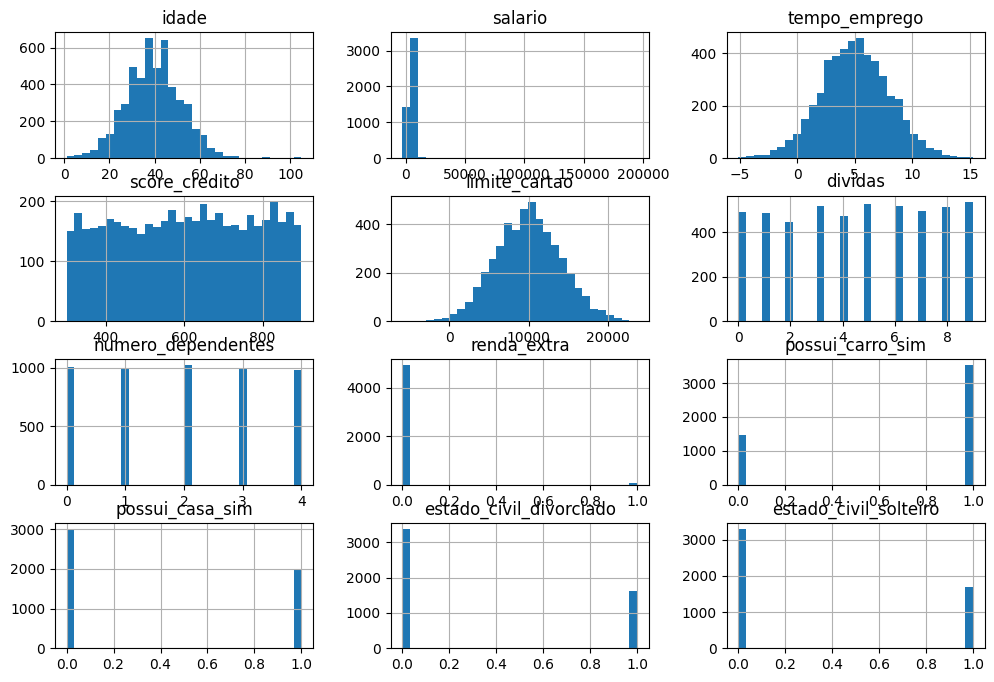

In [78]:
#analisando distribuição das variáveis numéricas
num_vars = ["idade", "salario", "tempo_emprego", "score_credito", "limite_cartao", "dividas", 'numero_dependentes', 'renda_extra', 'possui_carro_sim','possui_casa_sim', 'estado_civil_divorciado', 'estado_civil_solteiro']
df[num_vars].hist(figsize=(12, 8), bins=30)
plt.show()

Conclusão

Distribuição normal:
- idade
- tempo de emprego
- limite_cartao

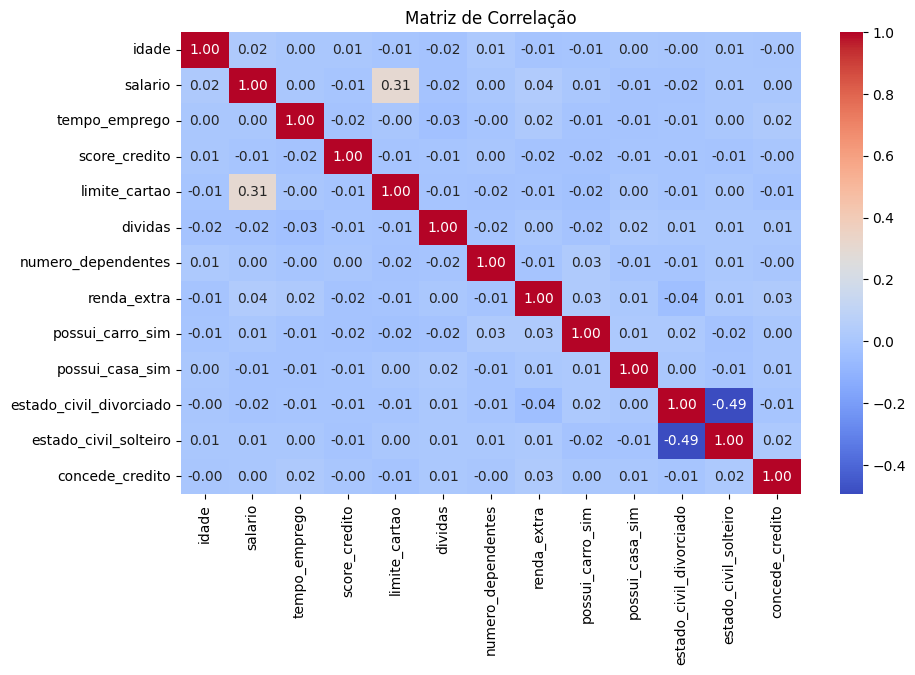

In [79]:
#analisando correlação entre as features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Conclusão: 

Features correlacionadas:

- limite_cartao x tempo_emprego
- salario x limite_cartao

Feature correlacionadas ao target:

- tempo_emprego
- renda_extra
- dividas

Outliers em idade: 49 outliers


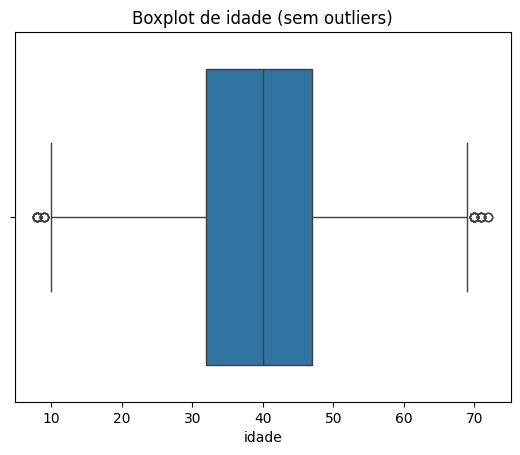

Outliers em salario: 40 outliers


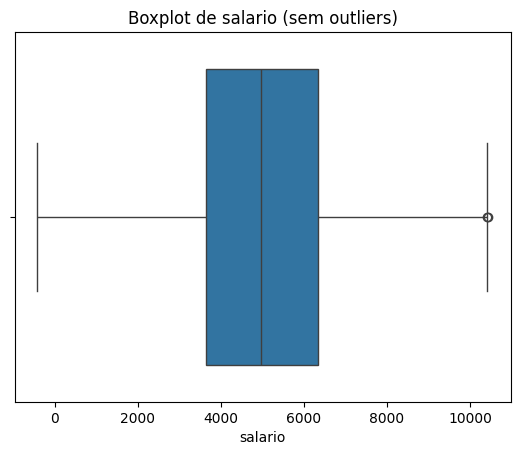

Outliers em tempo_emprego: 45 outliers


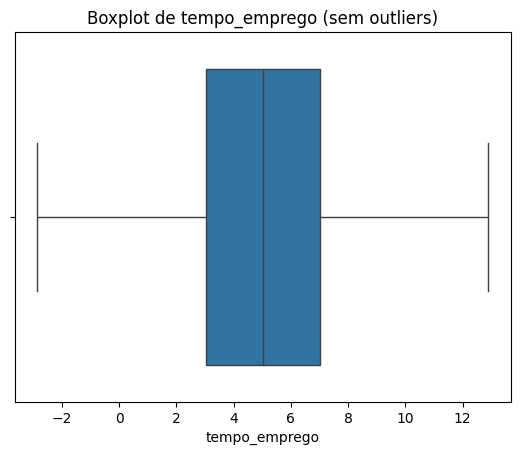

Outliers em score_credito: 0 outliers


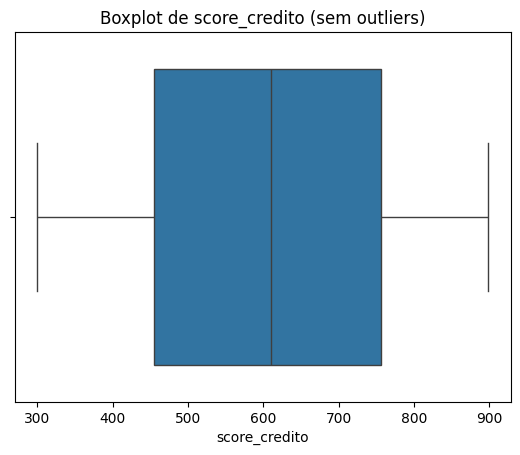

Outliers em limite_cartao: 14 outliers


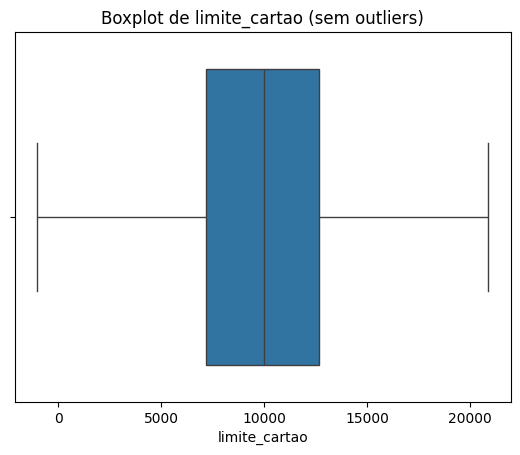

Outliers em dividas: 0 outliers


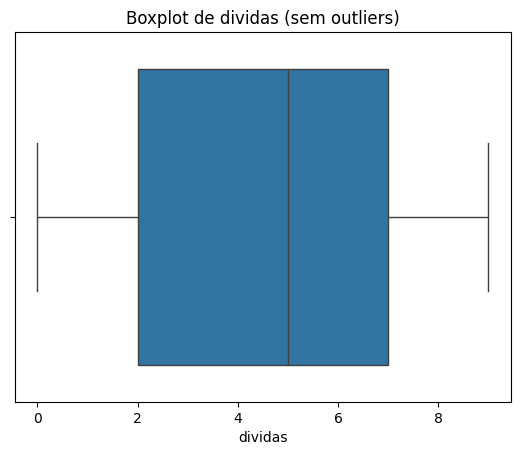

Outliers em numero_dependentes: 0 outliers


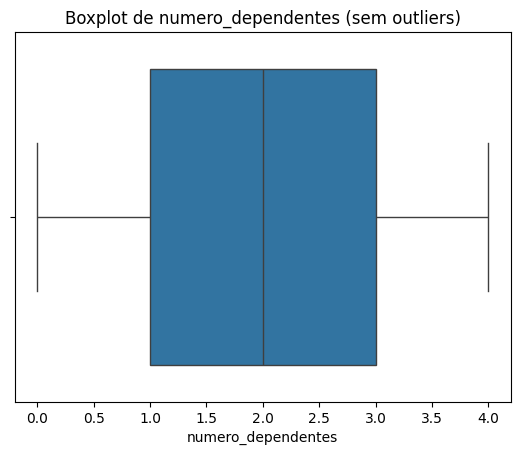

Outliers em renda_extra: 61 outliers


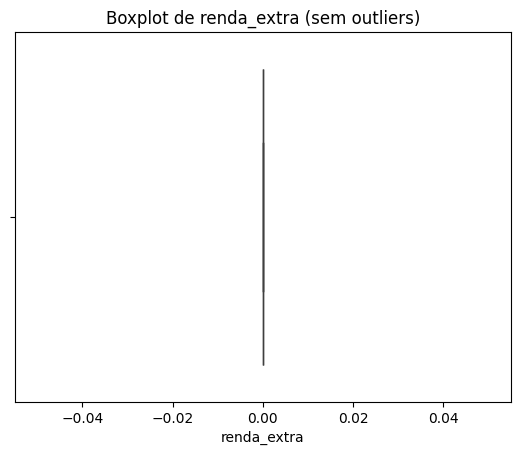

Outliers em possui_carro_sim: 0 outliers


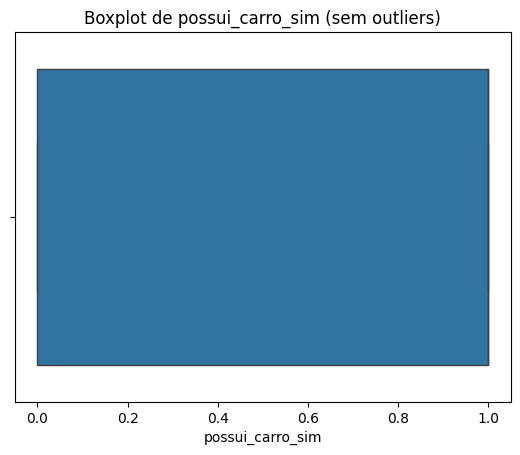

Outliers em possui_casa_sim: 0 outliers


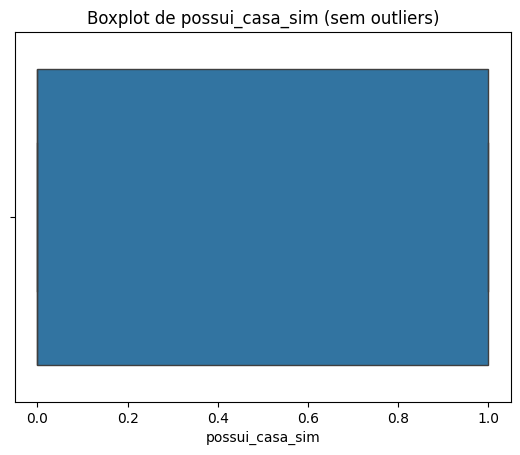

Outliers em estado_civil_divorciado: 0 outliers


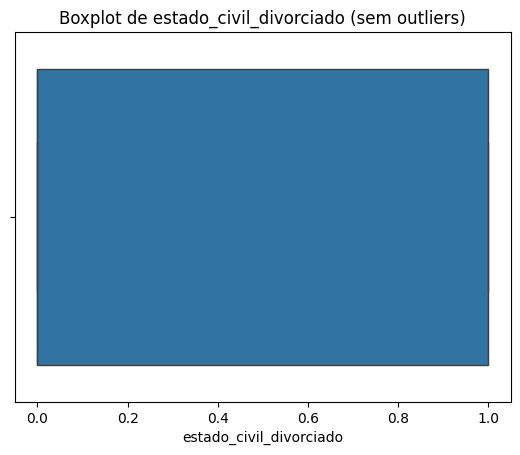

Outliers em estado_civil_solteiro: 0 outliers


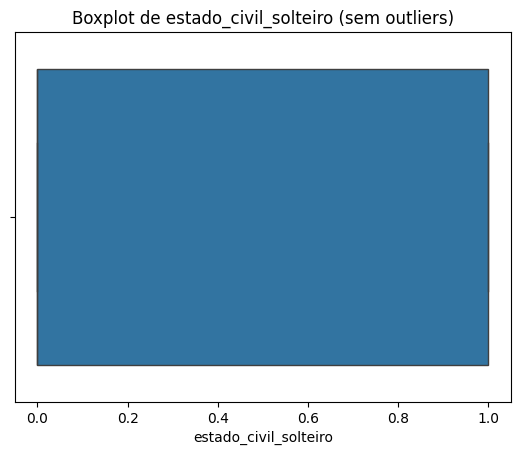

In [80]:
# Iterando sobre as variáveis numéricas
for col in num_vars:
    # Calculando o IQR para detectar outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificando os outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    # Contando os outliers
    outliers_count = outliers.sum()
    print(f'Outliers em {col}: {outliers_count} outliers')

    # Remover outliers do DataFrame
    df = df[~outliers]

    # Gerando o boxplot com os dados sem outliers
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col} (sem outliers)")
    plt.show()




conclusão:

Features com outliers:

- idade
- salario
- tempo emprego
- limite_cartão

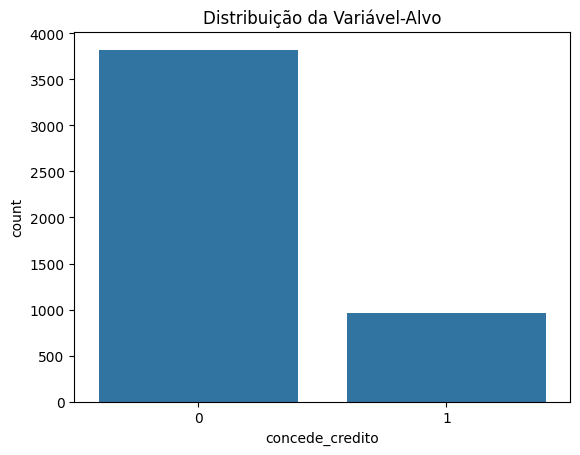

In [81]:
#analisando balanceamento das classes
sns.countplot(x=df["concede_credito"])
plt.title("Distribuição da Variável-Alvo")
plt.show()


# Divisão Treino e Teste

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [83]:
# divisão dos dados em treino e teste

x = df.drop(columns= ['concede_credito'])
y = df.concede_credito

In [84]:
x_train, x_test, y_train, y_test = train_test_split (x,y, test_size= 0.2, random_state= 0)

In [85]:
# SMOTE aplciado a seguir não aceita valores NaN, portanto eles serão substituidos por média ou moda conforme o tipo de variável.

colunas_numericas = ['salario' , 'tempo_emprego', 'limite_cartao' ]

In [86]:
x_train[colunas_numericas] = SimpleImputer(strategy='mean').fit_transform(x_train[colunas_numericas])

In [114]:
# Aplicando SMOTE no conjunto de treino
smote = SMOTE(sampling_strategy=0.3, random_state=42)
x_train_bal, y_train_bal = smote.fit_resample(x_train, y_train)

In [115]:

# Verificando a nova distribuição das classes
from collections import Counter
print("Distribuição antes do SMOTE:", Counter(y_train))
print("Distribuição depois do SMOTE:", Counter(y_train_bal))

Distribuição antes do SMOTE: Counter({0: 3063, 1: 769})
Distribuição depois do SMOTE: Counter({0: 3063, 1: 918})


#Treinamento do modelo

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [117]:
model_tree = DecisionTreeClassifier (max_depth=10, class_weight="balanced") #(
model_tree.fit(x_train_bal, y_train_bal)
pred_tree = model_tree.predict(x_test)

In [118]:
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.80      0.52      0.63       761
           1       0.21      0.50      0.30       198

    accuracy                           0.52       959
   macro avg       0.51      0.51      0.46       959
weighted avg       0.68      0.52      0.56       959



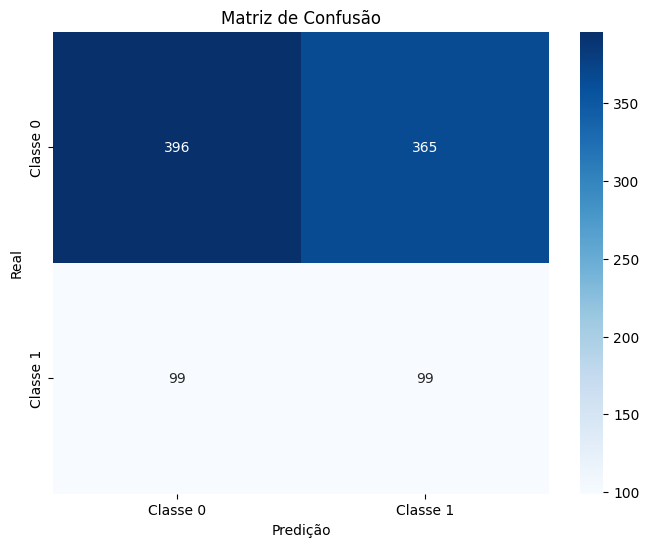

In [119]:

conf_matrix = confusion_matrix(y_test, pred_tree)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()